In [1]:
%load_ext autoreload

In [76]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda, LightningWrapper
from gpt.alt_model import ViT as AltViT
from gpt.data import MNISTDataModule, CIFAR10DataModule, AddGaussianNoise
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from rich.progress import track

In [150]:
mnist = CIFAR10DataModule(root_dir='/scratch/gpfs/js5013/data/ml/', num_workers=4, batch_size=8)
mnist.setup()

In [151]:
tl = mnist.test_dataloader()

In [152]:
x, y = next(iter(tl))

In [165]:
model = LightningWrapper.load_from_checkpoint('../train/lightning_logs/version_1023348/checkpoints/epoch=23-step=9384.ckpt')
model.freeze()

/scratch/gpfs/js5013/.conda/envs/foundation/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'output_head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_head'])`.


In [166]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(None, ['cat', 'dog', 'cat', 'ship', 'cat', 'dog', 'automobile', 'horse'])

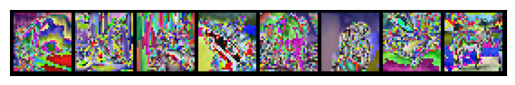

In [167]:
show(torchvision.utils.make_grid(x + torch.randn(x.shape) * torch.std(x, axis=(0, 2, 3), keepdim=True) * 0.0)), list(map(lambda i: mnist.classes[i], y))

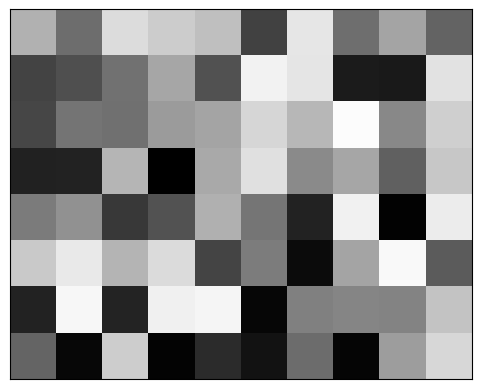

In [168]:
show(torchvision.utils.make_grid(model(x.cuda())))

In [170]:
list(map(lambda i: mnist.classes[i], torch.argmax(model(x.cuda()), axis=1)))

['cat', 'cat', 'cat', 'ship', 'dog', 'cat', 'automobile', 'horse']

In [171]:
score = 0
total = 0
for x, y in track(tl, total=len(tl)):
    with torch.no_grad():
        out = model(x.cuda())
        pred = torch.argmax(out, 1).cpu()
    score += torch.sum(pred == y)
    total += x.shape[0]

Output()

In [172]:
score / total

tensor(0.5770)

In [140]:
def collate(lop):
    x, _ = zip(*lop)
    x = torch.stack(x)
    return x, x
    
cifar = CIFAR10DataModule(batch_size=64, collate_fn=collate, root_dir='/scratch/gpfs/js5013/data/ml/')
cifar.setup()

In [141]:
tl = cifar.test_dataloader()

In [142]:
x, y = next(iter(tl))

In [143]:
x.shape

torch.Size([64, 3, 32, 32])

In [144]:
y.shape

torch.Size([64, 3, 32, 32])